In [1]:
from pandapower.plotting import simple_plot
import pandapower as pp

No or insufficient geodata available --> Creating artificial coordinates. This may take some time


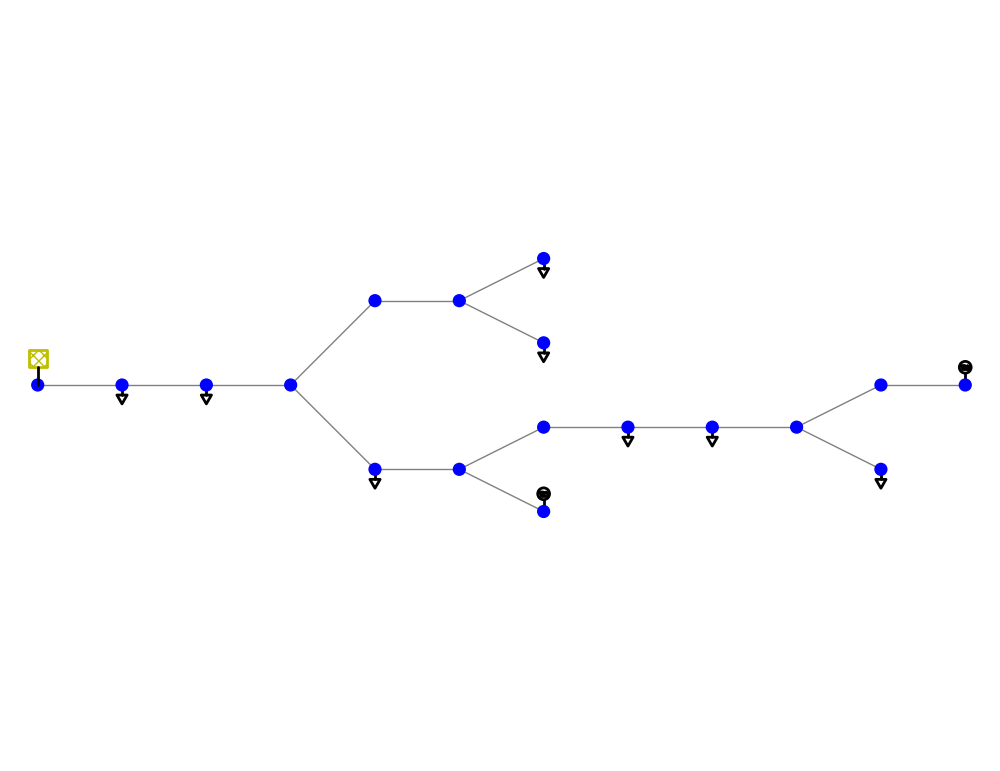

This pandapower network includes the following parameter tables:
   - bus (18 elements)
   - load (8 elements)
   - sgen (2 elements)
   - ext_grid (1 element)
   - line (17 elements)
   - bus_geodata (18 elements)


In [2]:
def Network_18_nodes_data():
    net = pp.create_empty_network(name="18bus_grid")
    pp.create_buses(net, 18, 11, min_vm_pu=0.95, max_vm_pu=1.05)
    pp.create_ext_grid(net, 0)
    idx = [1, 2, 4, 8, 9, 11, 16, 17]
    P = [0.1, 0.3, 0.4, 0.8, 0.8, 0.4, 0.1, 0.5]
    Q = [0.1, 0.1, 0.2, 0.4, 0.4, 0.2, 0.1, 0.3]
    pp.create_loads(net, idx, p_mw=P, q_mvar=Q)
    idx = [6, 13]
    P = [2.0, 5.]
    Q = [0.6, 2.0]
    pp.create_sgens(net, idx, P, Q)
    fbus = [0, 1, 2, 3, 4, 5, 5, 7, 8, 9, 10, 10, 12, 3, 14, 15, 15]
    tbus = list(range(1, 18))
    length_km = 1
    R = [0.0, 0.0174, 0.0001, 0.0052, 0.0003, 0.0010, 0.0017, 0.0022, 0.0001, 0.0016, 0.0007, 0.0299, 0.0010, 0.0025,
         0.0011, 0.0034, 0.0013]
    X = [0.1, 0.0085, 0.0001, 0.0028, 0.0002, 0.0010, 0.0008, 0.0011, 0.0000, 0.0008, 0.0003, 0.0081, 0.0010, 0.0007,
         0.0003, 0.0009, 0.0004]
    R = [k * 12.1 for k in R]
    X = [k * 12.1 for k in X]
    C = 0
    Imax = 0
    pp.create_lines_from_parameters(net, fbus, tbus, length_km, R, X, C, Imax)
    return net

net = Network_18_nodes_data()

simple_plot(net, plot_sgens=True, plot_loads=True)
print(net)

In [ ]:
%%time

import copy
import numpy as np
from tqdm import tqdm
import random


def generate_numbers(time_instants, n_bus):
    res = np.zeros((n_bus, time_instants))
    for i in range(n_bus):

        # Definizione dei parametri
        intervallo = np.arange(time_instants)
        frequenza = 0.02  # Regola la frequenza dell'andamento
        ampiezza = 1  # Regola l'ampiezza dell'andamento
        traslazione = 0.0  # Regola la traslazione verticale dell'andamento
        rumore = 0.2  # Regola la variazione casuale dell'andamento

        # Generazione dell'andamento
        andamento = ampiezza * np.sin(frequenza * intervallo) + traslazione
        andamento += rumore * np.random.normal(-1, 1, size=andamento.shape)
        res[i] = andamento
        #res[i][len(andamento)//2:] = 1

        '''
        plt.plot(intervallo, andamento)
        plt.xlabel('Tempo')
        plt.ylabel('Valore')
        plt.show()
        '''
    return res.T


# 600 timestep, ad ogni timestep i profili saranno aggiornati di un fattore moltiplicativo tra 0.5 e 1.5
original_p_values = copy.deepcopy(net.load.p_mw)
original_q_values = copy.deepcopy(net.load.q_mvar)
original_sgen_p = copy.deepcopy(net.sgen.p_mw)
original_sgen_q = copy.deepcopy(net.sgen.q_mvar)


load_profiles_p = generate_numbers(30000, len(net.load))
load_profiles_q = generate_numbers(30000, len(net.load))

pp.runpp(net)

res_p_mw = list([net.res_bus["p_mw"].values[1:]])
res_q_mvar = list([net.res_bus["q_mvar"].values[1:]])

v_bus_indices = [0, 3, 5, 10, 15]
res_vm_pu = list([net.res_bus["vm_pu"].values[v_bus_indices]])

res_all_vm_pu = list([net.res_bus["vm_pu"].values])

# p_q_indices = [0, 3, 6, 10, 11, 13, 15]
p_q_indices = [0, 3, 6, 10, 11, 13, 15]
res_p_mw_lines = list([net.res_line["p_from_mw"].values[p_q_indices]])
res_q_mvar_lines = list([net.res_line["q_from_mvar"].values[p_q_indices]])

for p_factor, q_factor in tqdm(zip(load_profiles_p, load_profiles_q), total=30000):
    while True:
        try:

            net.ext_grid.at[0, 'vm_pu'] = random.uniform(0.95, 1.05)

            # aggiorno load di p e q
            for i in range(len(net.load.p_mw)):
                net.load.p_mw[i] = original_p_values[i] * abs(p_factor[i])
                net.load.q_mvar[i] = original_q_values[i] * abs(q_factor[i])

                #net.load.p_mw[i] = random.uniform(0.9, 1.1) * original_p_values[i]
                #net.load.q_mvar[i] = random.uniform(0.9, 1.1) * original_q_values[i]

            bias = (random.random() * 2 - 1) / 2.

            add_bias = (random.random() > .5) / 2.
            for i in range(len(net.sgen.p_mw)):
                if add_bias:
                    net.sgen.p_mw[i] = min(1., abs(bias + random.random())) * original_sgen_p[i]
                    net.sgen.q_mvar[i] = min(1., abs(bias + random.random())) * original_sgen_q[i]
                else:
                    net.sgen.p_mw[i] = random.random() * original_sgen_p[i]
                    net.sgen.q_mvar[i] = random.random() * original_sgen_q[i]

            pp.runpp(net, max_iteration=5000)
            break
        except:
            pass
    # for i in range(len(net.res_bus["vm_pu"].values)):
    #    pp.create_measurement(net, 'p', 'bus', net.res_bus["vm_pu"].values[i], 0.003, i)

    res_p_mw.append(net.res_bus["p_mw"].values[1:])
    res_q_mvar.append(net.res_bus["q_mvar"].values[1:])
    res_vm_pu.append(net.res_bus["vm_pu"].values[v_bus_indices])
    res_p_mw_lines.append(net.res_line['p_from_mw'].values[p_q_indices])
    res_q_mvar_lines.append(net.res_line['q_from_mvar'].values[p_q_indices])
    res_all_vm_pu.append(net.res_bus["vm_pu"].values)

# aggiungo rumore introdotto dallo strumento di misura
measured_p_mw = list(np.random.normal(res_p_mw, 0.003))
measured_q_mvar = list(np.random.normal(res_q_mvar, 0.003))
measured_vm_pu = list(np.random.normal(res_vm_pu, 0.003))
measured_all_vm_pu = list(np.random.normal(res_all_vm_pu, 0.003))
measured_p_mw_lines = list(np.random.normal(res_p_mw_lines, 0.003))
measured_q_mvar_lines = list(np.random.normal(res_q_mvar_lines, 0.003))

data_x = np.hstack((res_p_mw, res_q_mvar, res_vm_pu, res_p_mw_lines, res_q_mvar_lines))
measured_data_x = np.hstack(
    (measured_p_mw, measured_q_mvar, measured_vm_pu, measured_p_mw_lines, measured_q_mvar_lines))
data_y = res_all_vm_pu
measured_data_y = measured_all_vm_pu



np.save('./net_18_v1/data_x_alt.npy', data_x)
np.save('./net_18_v1/data_y_alt.npy', data_y)
np.save('./net_18_v1/measured_data_x_alt.npy', measured_data_x)
np.save('./net_18_v1/measured_data_y_alt.npy', measured_data_y)

In [ ]:
'''
CPU times: total: 45.7 s
Wall time: 3min 21s
'''

No or insufficient geodata available --> Creating artificial coordinates. This may take some time


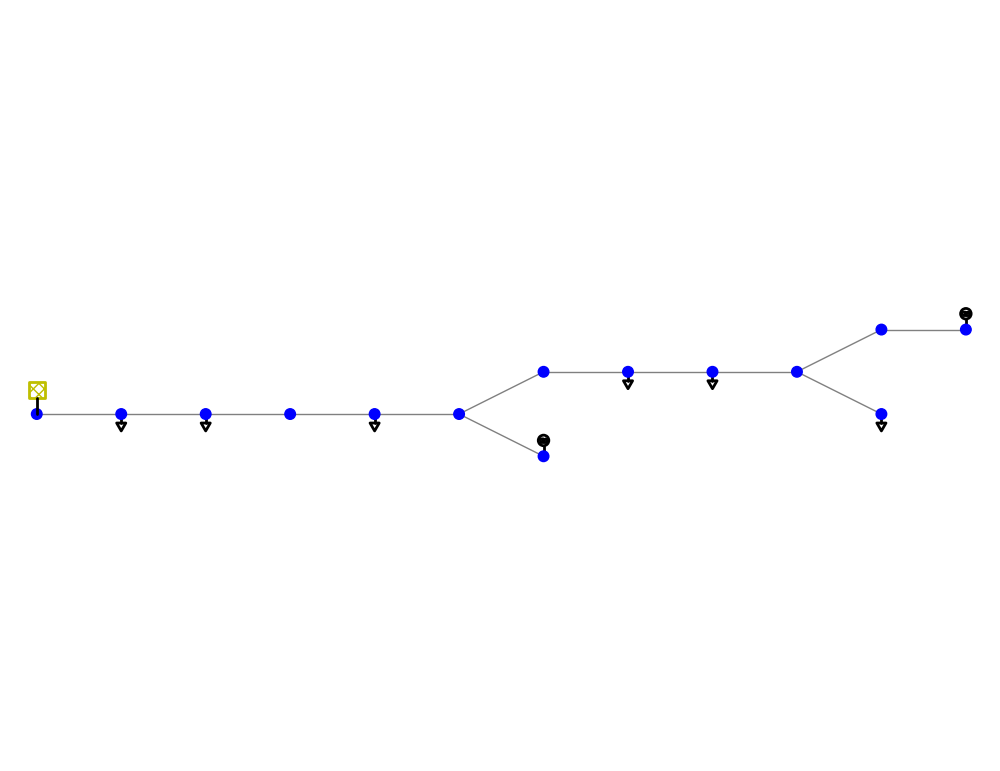

This pandapower network includes the following parameter tables:
   - bus (14 elements)
   - load (6 elements)
   - sgen (2 elements)
   - ext_grid (1 element)
   - line (13 elements)
   - bus_geodata (14 elements)


In [3]:
def Network_18_nodes_datav2():
    net = pp.create_empty_network(name="18bus_grid")
    pp.create_buses(net, 14, 11, min_vm_pu=0.95, max_vm_pu=1.05)
    pp.create_ext_grid(net, 0)
    idx = [1, 2, 4, 8, 9, 11]
    P = [0.1, 0.3, 0.4, 0.8, 0.8, 0.4]
    Q = [0.1, 0.1, 0.2, 0.4, 0.4, 0.2]
    pp.create_loads(net, idx, p_mw=P, q_mvar=Q)
    idx = [6, 13]
    P = [2.0, 5.]
    Q = [0.6, 2.0]
    pp.create_sgens(net, idx, P, Q)
    fbus = [0, 1, 2, 3, 4, 5, 5, 7, 8, 9, 10, 10, 12]
    tbus = list(range(1, 14))
    length_km = 1
    R = [0.0, 0.0174, 0.0001, 0.0052, 0.0003, 0.0010, 0.0017, 0.0022, 0.0001, 0.0016, 0.0007, 0.0299, 0.0010]
    X = [0.1, 0.0085, 0.0001, 0.0028, 0.0002, 0.0010, 0.0008, 0.0011, 0.0000, 0.0008, 0.0003, 0.0081, 0.0010]
    R = [k * 12.1 for k in R]
    X = [k * 12.1 for k in X]
    C = 0
    Imax = 0
    pp.create_lines_from_parameters(net, fbus, tbus, length_km, R, X, C, Imax)
    return net

net = Network_18_nodes_datav2()

simple_plot(net, plot_sgens=True, plot_loads=True)
print(net)

In [ ]:
%%time

import copy
import numpy as np
from tqdm import tqdm
import random


def generate_numbers(time_instants, n_bus):
    res = np.zeros((n_bus, time_instants))
    for i in range(n_bus):

        # Definizione dei parametri
        intervallo = np.arange(time_instants)
        frequenza = 0.02  # Regola la frequenza dell'andamento
        ampiezza = 1  # Regola l'ampiezza dell'andamento
        traslazione = 0.0  # Regola la traslazione verticale dell'andamento
        rumore = 0.2  # Regola la variazione casuale dell'andamento

        # Generazione dell'andamento
        andamento = ampiezza * np.sin(frequenza * intervallo) + traslazione
        andamento += rumore * np.random.normal(-1, 1, size=andamento.shape)
        res[i] = andamento
        #res[i][len(andamento)//2:] = 1

        '''
        plt.plot(intervallo, andamento)
        plt.xlabel('Tempo')
        plt.ylabel('Valore')
        plt.show()
        '''
    return res.T


# 600 timestep, ad ogni timestep i profili saranno aggiornati di un fattore moltiplicativo tra 0.5 e 1.5
original_p_values = copy.deepcopy(net.load.p_mw)
original_q_values = copy.deepcopy(net.load.q_mvar)
original_sgen_p = copy.deepcopy(net.sgen.p_mw)
original_sgen_q = copy.deepcopy(net.sgen.q_mvar)

load_profiles_p = generate_numbers(30000, len(net.load))
load_profiles_q = generate_numbers(30000, len(net.load))

pp.runpp(net)

res_p_mw = list([net.res_bus["p_mw"].values[1:]])
res_q_mvar = list([net.res_bus["q_mvar"].values[1:]])

v_bus_indices = [0, 3, 5, 10]
res_vm_pu = list([net.res_bus["vm_pu"].values[v_bus_indices]])

res_all_vm_pu = list([net.res_bus["vm_pu"].values])

# p_q_indices = [0, 3, 6, 10, 11, 13, 15]
p_q_indices = [0, 3, 6, 10, 11]
res_p_mw_lines = list([net.res_line["p_from_mw"].values[p_q_indices]])
res_q_mvar_lines = list([net.res_line["q_from_mvar"].values[p_q_indices]])

for p_factor, q_factor in tqdm(zip(load_profiles_p, load_profiles_q), total=30000):
    while True:
        try:

            net.ext_grid.at[0, 'vm_pu'] = random.uniform(0.95, 1.05)

            # aggiorno load di p e q
            for i in range(len(net.load.p_mw)):
                net.load.p_mw[i] = original_p_values[i] * abs(p_factor[i])
                net.load.q_mvar[i] = original_q_values[i] * abs(q_factor[i])

                #net.load.p_mw[i] = random.uniform(0.9, 1.1) * original_p_values[i]
                #net.load.q_mvar[i] = random.uniform(0.9, 1.1) * original_q_values[i]

            bias = (random.random() * 2 - 1) / 2.

            add_bias = (random.random() > .5) / 2.
            for i in range(len(net.sgen.p_mw)):
                if add_bias:
                    net.sgen.p_mw[i] = min(1., abs(bias + random.random())) * original_sgen_p[i]
                    net.sgen.q_mvar[i] = min(1., abs(bias + random.random())) * original_sgen_q[i]
                else:
                    net.sgen.p_mw[i] = random.random() * original_sgen_p[i]
                    net.sgen.q_mvar[i] = random.random() * original_sgen_q[i]
            pp.runpp(net, max_iteration=5000)
            break
        except:
            pass
    # for i in range(len(net.res_bus["vm_pu"].values)):
    #    pp.create_measurement(net, 'p', 'bus', net.res_bus["vm_pu"].values[i], 0.003, i)

    res_p_mw.append(net.res_bus["p_mw"].values[1:])
    res_q_mvar.append(net.res_bus["q_mvar"].values[1:])
    res_vm_pu.append(net.res_bus["vm_pu"].values[v_bus_indices])
    res_p_mw_lines.append(net.res_line['p_from_mw'].values[p_q_indices])
    res_q_mvar_lines.append(net.res_line['q_from_mvar'].values[p_q_indices])
    res_all_vm_pu.append(net.res_bus["vm_pu"].values)

# aggiungo rumore introdotto dallo strumento di misura
measured_p_mw = list(np.random.normal(res_p_mw, 0.003))
measured_q_mvar = list(np.random.normal(res_q_mvar, 0.003))
measured_vm_pu = list(np.random.normal(res_vm_pu, 0.003))
measured_all_vm_pu = list(np.random.normal(res_all_vm_pu, 0.003))
measured_p_mw_lines = list(np.random.normal(res_p_mw_lines, 0.003))
measured_q_mvar_lines = list(np.random.normal(res_q_mvar_lines, 0.003))

data_x = np.hstack((res_p_mw, res_q_mvar, res_vm_pu, res_p_mw_lines, res_q_mvar_lines))
measured_data_x = np.hstack(
    (measured_p_mw, measured_q_mvar, measured_vm_pu, measured_p_mw_lines, measured_q_mvar_lines))
data_y = res_all_vm_pu
measured_data_y = measured_all_vm_pu



np.save('./net_18_v2/data_x_alt.npy', data_x)
np.save('./net_18_v2/data_y_alt.npy', data_y)
np.save('./net_18_v2/measured_data_x_alt.npy', measured_data_x)
np.save('./net_18_v2/measured_data_y_alt.npy', measured_data_y)

In [ ]:
'''
CPU times: total: 40.4 s
Wall time: 3min 5s
'''

No or insufficient geodata available --> Creating artificial coordinates. This may take some time


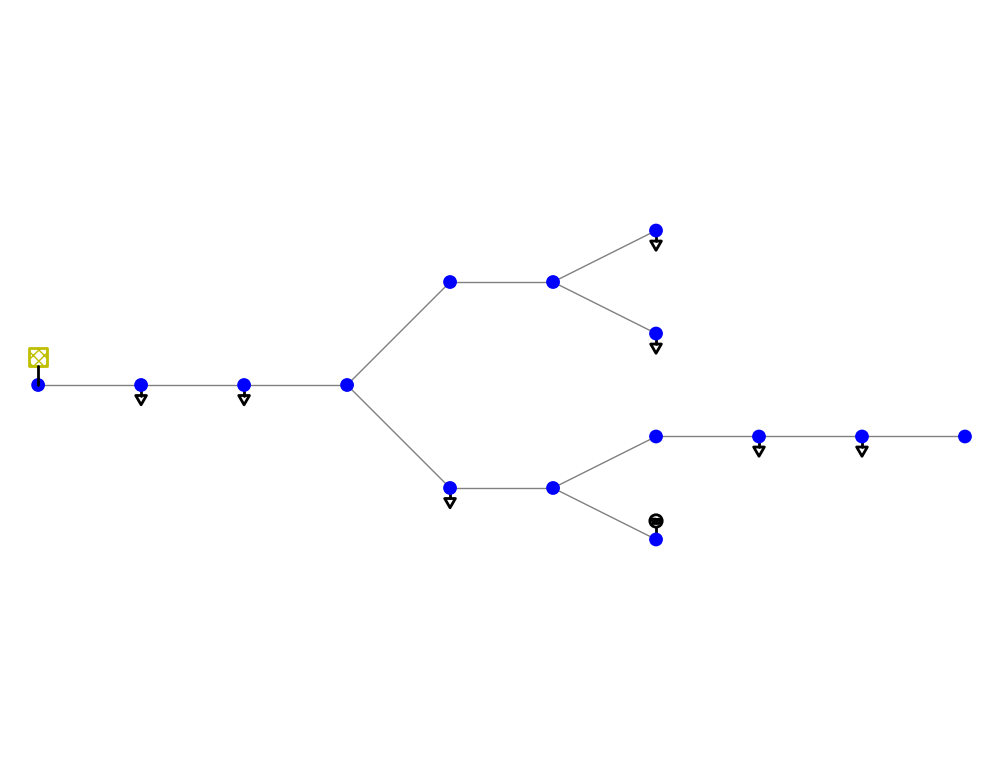

This pandapower network includes the following parameter tables:
   - bus (15 elements)
   - load (7 elements)
   - sgen (1 element)
   - ext_grid (1 element)
   - line (14 elements)
   - bus_geodata (15 elements)


In [20]:
def Network_18_nodes_datav3():
    net = pp.create_empty_network(name="18bus_grid")
    pp.create_buses(net, 15, 11, min_vm_pu=0.95, max_vm_pu=1.05)
    pp.create_ext_grid(net, 0)
    idx = [1, 2, 4, 8, 9, 13, 14]
    P = [0.1, 0.3, 0.4, 0.8, 0.8, 0.1, 0.5]
    Q = [0.1, 0.1, 0.2, 0.4, 0.4, 0.1, 0.3]
    pp.create_loads(net, idx, p_mw=P, q_mvar=Q)
    idx = [6]
    P = [2.0]
    Q = [0.6]
    pp.create_sgens(net, idx, P, Q)
    fbus = [0, 1, 2, 3, 4, 5, 5, 7, 8, 9, 3, 11, 12, 12]
    tbus = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    length_km = 1
    R = [0.0, 0.0174, 0.0001, 0.0052, 0.0003, 0.0010, 0.0017, 0.0022, 0.0001, 0.0016, 0.0025,
         0.0011, 0.0034, 0.0013]
    X = [0.1, 0.0085, 0.0001, 0.0028, 0.0002, 0.0010, 0.0008, 0.0011, 0.0000, 0.0008, 0.0007,
         0.0003, 0.0009, 0.0004]
    R = [k * 12.1 for k in R]
    X = [k * 12.1 for k in X]
    C = 0
    Imax = 0
    pp.create_lines_from_parameters(net, fbus, tbus, length_km, R, X, C, Imax)
    return net

net = Network_18_nodes_datav3()

simple_plot(net, plot_sgens=True, plot_loads=True)
print(net)

In [ ]:
%%time

import copy
import numpy as np
from tqdm import tqdm
import random


def generate_numbers(time_instants, n_bus):
    res = np.zeros((n_bus, time_instants))
    for i in range(n_bus):

        # Definizione dei parametri
        intervallo = np.arange(time_instants)
        frequenza = 0.02  # Regola la frequenza dell'andamento
        ampiezza = 1  # Regola l'ampiezza dell'andamento
        traslazione = 0.0  # Regola la traslazione verticale dell'andamento
        rumore = 0.2  # Regola la variazione casuale dell'andamento

        # Generazione dell'andamento
        andamento = ampiezza * np.sin(frequenza * intervallo) + traslazione
        andamento += rumore * np.random.normal(-1, 1, size=andamento.shape)
        res[i] = andamento
        #res[i][len(andamento)//2:] = 1

        '''
        plt.plot(intervallo, andamento)
        plt.xlabel('Tempo')
        plt.ylabel('Valore')
        plt.show()
        '''
    return res.T


# 600 timestep, ad ogni timestep i profili saranno aggiornati di un fattore moltiplicativo tra 0.5 e 1.5
original_p_values = copy.deepcopy(net.load.p_mw)
original_q_values = copy.deepcopy(net.load.q_mvar)
original_sgen_p = copy.deepcopy(net.sgen.p_mw)
original_sgen_q = copy.deepcopy(net.sgen.q_mvar)


load_profiles_p = generate_numbers(30000, len(net.load))
load_profiles_q = generate_numbers(30000, len(net.load))

pp.runpp(net)

res_p_mw = list([net.res_bus["p_mw"].values[1:]])
res_q_mvar = list([net.res_bus["q_mvar"].values[1:]])

v_bus_indices = [0, 3, 5, 10, 12]
res_vm_pu = list([net.res_bus["vm_pu"].values[v_bus_indices]])

res_all_vm_pu = list([net.res_bus["vm_pu"].values])

# p_q_indices = [0, 3, 6, 10, 11, 13, 15]
p_q_indices = [0, 3, 6, 10, 12]
res_p_mw_lines = list([net.res_line["p_from_mw"].values[p_q_indices]])
res_q_mvar_lines = list([net.res_line["q_from_mvar"].values[p_q_indices]])

for p_factor, q_factor in tqdm(zip(load_profiles_p, load_profiles_q), total=30000):
    while True:
        try:

            net.ext_grid.at[0, 'vm_pu'] = random.uniform(0.95, 1.05)

            # aggiorno load di p e q
            for i in range(len(net.load.p_mw)):
                net.load.p_mw[i] = original_p_values[i] * abs(p_factor[i])
                net.load.q_mvar[i] = original_q_values[i] * abs(q_factor[i])

                #net.load.p_mw[i] = random.uniform(0.9, 1.1) * original_p_values[i]
                #net.load.q_mvar[i] = random.uniform(0.9, 1.1) * original_q_values[i]

            bias = (random.random() * 2 - 1) / 2.

            add_bias = (random.random() > .5) / 2.
            for i in range(len(net.sgen.p_mw)):
                if add_bias:
                    net.sgen.p_mw[i] = min(1., abs(bias + random.random())) * original_sgen_p[i]
                    net.sgen.q_mvar[i] = min(1., abs(bias + random.random())) * original_sgen_q[i]
                else:
                    net.sgen.p_mw[i] = random.random() * original_sgen_p[i]
                    net.sgen.q_mvar[i] = random.random() * original_sgen_q[i]

            pp.runpp(net, max_iteration=5000)
            break
        except:
            pass
    # for i in range(len(net.res_bus["vm_pu"].values)):
    #    pp.create_measurement(net, 'p', 'bus', net.res_bus["vm_pu"].values[i], 0.003, i)

    res_p_mw.append(net.res_bus["p_mw"].values[1:])
    res_q_mvar.append(net.res_bus["q_mvar"].values[1:])
    res_vm_pu.append(net.res_bus["vm_pu"].values[v_bus_indices])
    res_p_mw_lines.append(net.res_line['p_from_mw'].values[p_q_indices])
    res_q_mvar_lines.append(net.res_line['q_from_mvar'].values[p_q_indices])
    res_all_vm_pu.append(net.res_bus["vm_pu"].values)

# aggiungo rumore introdotto dallo strumento di misura
measured_p_mw = list(np.random.normal(res_p_mw, 0.003))
measured_q_mvar = list(np.random.normal(res_q_mvar, 0.003))
measured_vm_pu = list(np.random.normal(res_vm_pu, 0.003))
measured_all_vm_pu = list(np.random.normal(res_all_vm_pu, 0.003))
measured_p_mw_lines = list(np.random.normal(res_p_mw_lines, 0.003))
measured_q_mvar_lines = list(np.random.normal(res_q_mvar_lines, 0.003))

data_x = np.hstack((res_p_mw, res_q_mvar, res_vm_pu, res_p_mw_lines, res_q_mvar_lines))
measured_data_x = np.hstack(
    (measured_p_mw, measured_q_mvar, measured_vm_pu, measured_p_mw_lines, measured_q_mvar_lines))
data_y = res_all_vm_pu
measured_data_y = measured_all_vm_pu



np.save('./net_18_v3/data_x_alt.npy', data_x)
np.save('./net_18_v3/data_y_alt.npy', data_y)
np.save('./net_18_v3/measured_data_x_alt.npy', measured_data_x)
np.save('./net_18_v3/measured_data_y_alt.npy', measured_data_y)

In [ ]:
'''
CPU times: total: 44.5 s
Wall time: 2min 52s
'''

No or insufficient geodata available --> Creating artificial coordinates. This may take some time


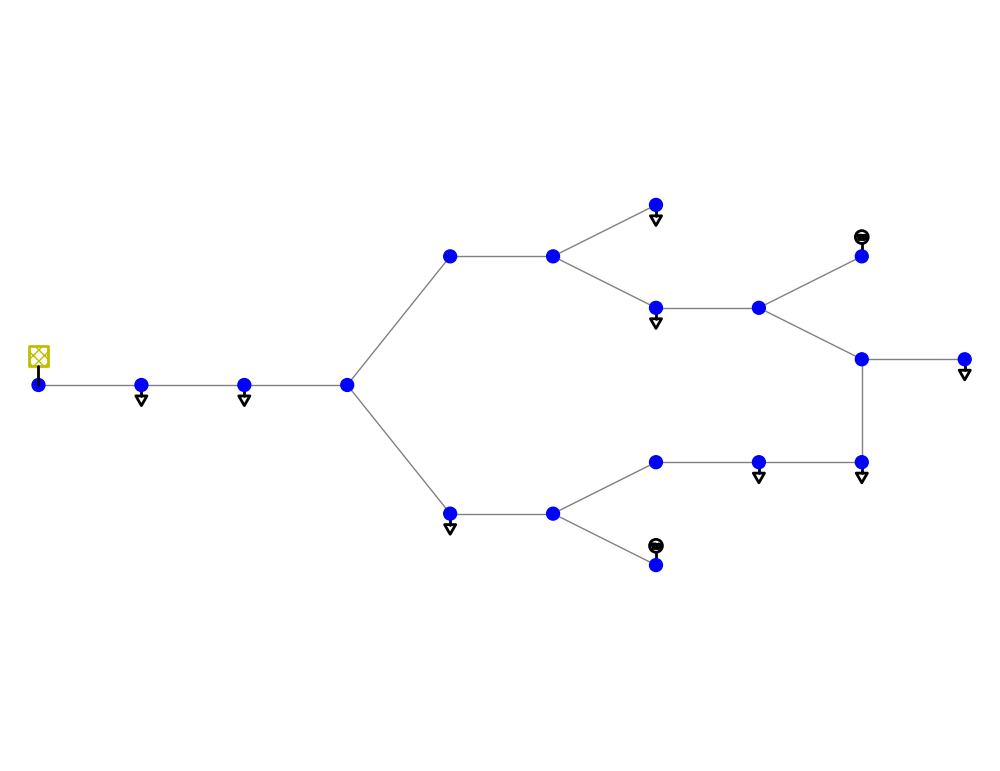

This pandapower network includes the following parameter tables:
   - bus (18 element)
   - load (8 element)
   - sgen (2 element)
   - ext_grid (1 elements)
   - line (18 element)
   - bus_geodata (18 element)


In [2]:
def Network_18_nodes_datav4():
    net = pp.create_empty_network(name="18bus_grid")
    pp.create_buses(net, 18, 11, min_vm_pu=0.95, max_vm_pu=1.05)
    pp.create_ext_grid(net, 0)
    idx = [1, 2, 4, 8, 9, 11, 16, 17]
    P = [0.1, 0.3, 0.4, 0.8, 0.8, 0.4, 0.1, 0.5]
    Q = [0.1, 0.1, 0.2, 0.4, 0.4, 0.2, 0.1, 0.3]
    pp.create_loads(net, idx, p_mw=P, q_mvar=Q)
    idx = [6, 13]
    P = [2.0, 5.]
    Q = [0.6, 2.0]
    pp.create_sgens(net, idx, P, Q)
    fbus = [0, 1, 2, 3, 4, 5, 5, 7, 8, 9, 10, 10, 12, 3, 14, 15, 15, 16]
    tbus = list(range(1, 18)) + [12]
    length_km = 1
    R = [0.0, 0.0174, 0.0001, 0.0052, 0.0003, 0.0010, 0.0017, 0.0022, 0.0001, 0.0016, 0.0007, 0.0299, 0.0010, 0.0025,
         0.0011, 0.0034, 0.0013, 0.0025]
    X = [0.1, 0.0085, 0.0001, 0.0028, 0.0002, 0.0010, 0.0008, 0.0011, 0.0000, 0.0008, 0.0003, 0.0081, 0.0010, 0.0007,
         0.0003, 0.0009, 0.0004, 0.0007]
    R = [k * 12.1 for k in R]
    X = [k * 12.1 for k in X]
    C = 0
    Imax = 0
    pp.create_lines_from_parameters(net, fbus, tbus, length_km, R, X, C, Imax)
    return net


net = Network_18_nodes_datav4()

simple_plot(net, plot_sgens=True, plot_loads=True)
print(net)

In [ ]:
%%time

import copy
import numpy as np
from tqdm import tqdm
import random


def generate_numbers(time_instants, n_bus):
    res = np.zeros((n_bus, time_instants))
    for i in range(n_bus):

        # Definizione dei parametri
        intervallo = np.arange(time_instants)
        frequenza = 0.02  # Regola la frequenza dell'andamento
        ampiezza = 1  # Regola l'ampiezza dell'andamento
        traslazione = 0.0  # Regola la traslazione verticale dell'andamento
        rumore = 0.2  # Regola la variazione casuale dell'andamento

        # Generazione dell'andamento
        andamento = ampiezza * np.sin(frequenza * intervallo) + traslazione
        andamento += rumore * np.random.normal(-1, 1, size=andamento.shape)
        res[i] = andamento
        #res[i][len(andamento)//2:] = 1

        '''
        plt.plot(intervallo, andamento)
        plt.xlabel('Tempo')
        plt.ylabel('Valore')
        plt.show()
        '''
    return res.T


# 600 timestep, ad ogni timestep i profili saranno aggiornati di un fattore moltiplicativo tra 0.5 e 1.5
original_p_values = copy.deepcopy(net.load.p_mw)
original_q_values = copy.deepcopy(net.load.q_mvar)
original_sgen_p = copy.deepcopy(net.sgen.p_mw)
original_sgen_q = copy.deepcopy(net.sgen.q_mvar)


load_profiles_p = generate_numbers(30000, len(net.load))
load_profiles_q = generate_numbers(30000, len(net.load))

pp.runpp(net)

res_p_mw = list([net.res_bus["p_mw"].values[1:]])
res_q_mvar = list([net.res_bus["q_mvar"].values[1:]])

v_bus_indices = [0, 3, 5, 10, 15]
res_vm_pu = list([net.res_bus["vm_pu"].values[v_bus_indices]])

res_all_vm_pu = list([net.res_bus["vm_pu"].values])

# p_q_indices = [0, 3, 6, 10, 11, 13, 15]
p_q_indices = [0, 3, 6, 10, 11, 13, 15]
res_p_mw_lines = list([net.res_line["p_from_mw"].values[p_q_indices]])
res_q_mvar_lines = list([net.res_line["q_from_mvar"].values[p_q_indices]])
for p_factor, q_factor in tqdm(zip(load_profiles_p, load_profiles_q), total=30000):
    while True:
        try:

            net.ext_grid.at[0, 'vm_pu'] = random.uniform(0.95, 1.05)

            # aggiorno load di p e q
            for i in range(len(net.load.p_mw)):
                net.load.p_mw[i] = original_p_values[i] * abs(p_factor[i])
                net.load.q_mvar[i] = original_q_values[i] * abs(q_factor[i])

                #net.load.p_mw[i] = random.uniform(0.9, 1.1) * original_p_values[i]
                #net.load.q_mvar[i] = random.uniform(0.9, 1.1) * original_q_values[i]

            bias = (random.random() * 2 - 1) / 2.

            add_bias = (random.random() > .5) / 2.
            for i in range(len(net.sgen.p_mw)):
                if add_bias:
                    net.sgen.p_mw[i] = min(1., abs(bias + random.random())) * original_sgen_p[i]
                    net.sgen.q_mvar[i] = min(1., abs(bias + random.random())) * original_sgen_q[i]
                else:
                    net.sgen.p_mw[i] = random.random() * original_sgen_p[i]
                    net.sgen.q_mvar[i] = random.random() * original_sgen_q[i]
            pp.runpp(net)
            break
        except:
            pass
    # for i in range(len(net.res_bus["vm_pu"].values)):
    #    pp.create_measurement(net, 'p', 'bus', net.res_bus["vm_pu"].values[i], 0.003, i)
    
    res_p_mw.append(net.res_bus["p_mw"].values[1:])
    res_q_mvar.append(net.res_bus["q_mvar"].values[1:])
    res_vm_pu.append(net.res_bus["vm_pu"].values[v_bus_indices])
    res_p_mw_lines.append(net.res_line['p_from_mw'].values[p_q_indices])
    res_q_mvar_lines.append(net.res_line['q_from_mvar'].values[p_q_indices])
    res_all_vm_pu.append(net.res_bus["vm_pu"].values)

# aggiungo rumore introdotto dallo strumento di misura
measured_p_mw = list(np.random.normal(res_p_mw, 0.003))
measured_q_mvar = list(np.random.normal(res_q_mvar, 0.003))
measured_vm_pu = list(np.random.normal(res_vm_pu, 0.003))
measured_all_vm_pu = list(np.random.normal(res_all_vm_pu, 0.003))
measured_p_mw_lines = list(np.random.normal(res_p_mw_lines, 0.003))
measured_q_mvar_lines = list(np.random.normal(res_q_mvar_lines, 0.003))

data_x = np.hstack((res_p_mw, res_q_mvar, res_vm_pu, res_p_mw_lines, res_q_mvar_lines))
measured_data_x = np.hstack(
    (measured_p_mw, measured_q_mvar, measured_vm_pu, measured_p_mw_lines, measured_q_mvar_lines))
data_y = res_all_vm_pu
measured_data_y = measured_all_vm_pu



np.save('./net_18_v4/data_x_alt.npy', data_x)
np.save('./net_18_v4/data_y_alt.npy', data_y)
np.save('./net_18_v4/measured_data_x_alt.npy', measured_data_x)
np.save('./net_18_v4/measured_data_y_alt.npy', measured_data_y)

In [ ]:
# v4
#CPU times: total: 1min 5s
#Wall time: 5min 32s